<a href="https://colab.research.google.com/github/canamac/zeka-can/blob/main/2_Finans_i%C3%A7in_Python_SMA_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  Cloning https://github.com/rongardF/tvdatafeed to /tmp/pip-req-build-wal6eh5t
  Running command git clone --filter=blob:none --quiet https://github.com/rongardF/tvdatafeed /tmp/pip-req-build-wal6eh5t
  Resolved https://github.com/rongardF/tvdatafeed to commit e6f6aaa7de439ac6e454d9b26d2760ded8dc4923
  Preparing metadata (setup.py) ... done
  Created wheel for tvdatafeed: filename=tvdatafeed-2.1.0-py3-none-any.whl size=17533 sha256=1b0a4edd960521c80f3a3e2d00728980b7a7aa982d42a16274d3108ebce7ffab
  Stored in directory: /tmp/pip-ephem-wheel-cache-tb0dll45/wheels/e4/32/1e/21ebcacc6549d75fae3bf3ff75cee8fcbe4e5c189d88fbd5a1
Successfully built tvdatafeed
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 861.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 36.7 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
ERROR: pip's dependency res

/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


                         symbol   open   high    low  close      volume
datetime                                                               
2024-02-21 10:00:00  BIST:EREGL  49.82  49.84  48.74  48.94  42841535.0
2024-02-21 11:00:00  BIST:EREGL  48.94  49.16  47.88  49.08  73823787.0
2024-02-21 12:00:00  BIST:EREGL  49.06  49.50  48.62  48.80  54172758.0
2024-02-21 13:00:00  BIST:EREGL  48.80  49.20  48.56  48.64  19788685.0
2024-02-21 14:00:00  BIST:EREGL  48.66  48.96  48.34  48.78  32333606.0
...                         ...    ...    ...    ...    ...         ...
2024-07-23 11:00:00  BIST:EREGL  58.70  58.70  58.30  58.50  16951591.0
2024-07-23 12:00:00  BIST:EREGL  58.50  58.60  58.35  58.45  14815286.0
2024-07-23 13:00:00  BIST:EREGL  58.50  58.50  58.15  58.50  14597964.0
2024-07-23 14:00:00  BIST:EREGL  58.45  58.60  58.20  58.35  30652660.0
2024-07-23 15:00:00  BIST:EREGL  58.40  58.40  58.35  58.35   8369923.0

[1000 rows x 6 columns]
     SMA Kısa  SMA Uzun  Getiri Yüzdesi

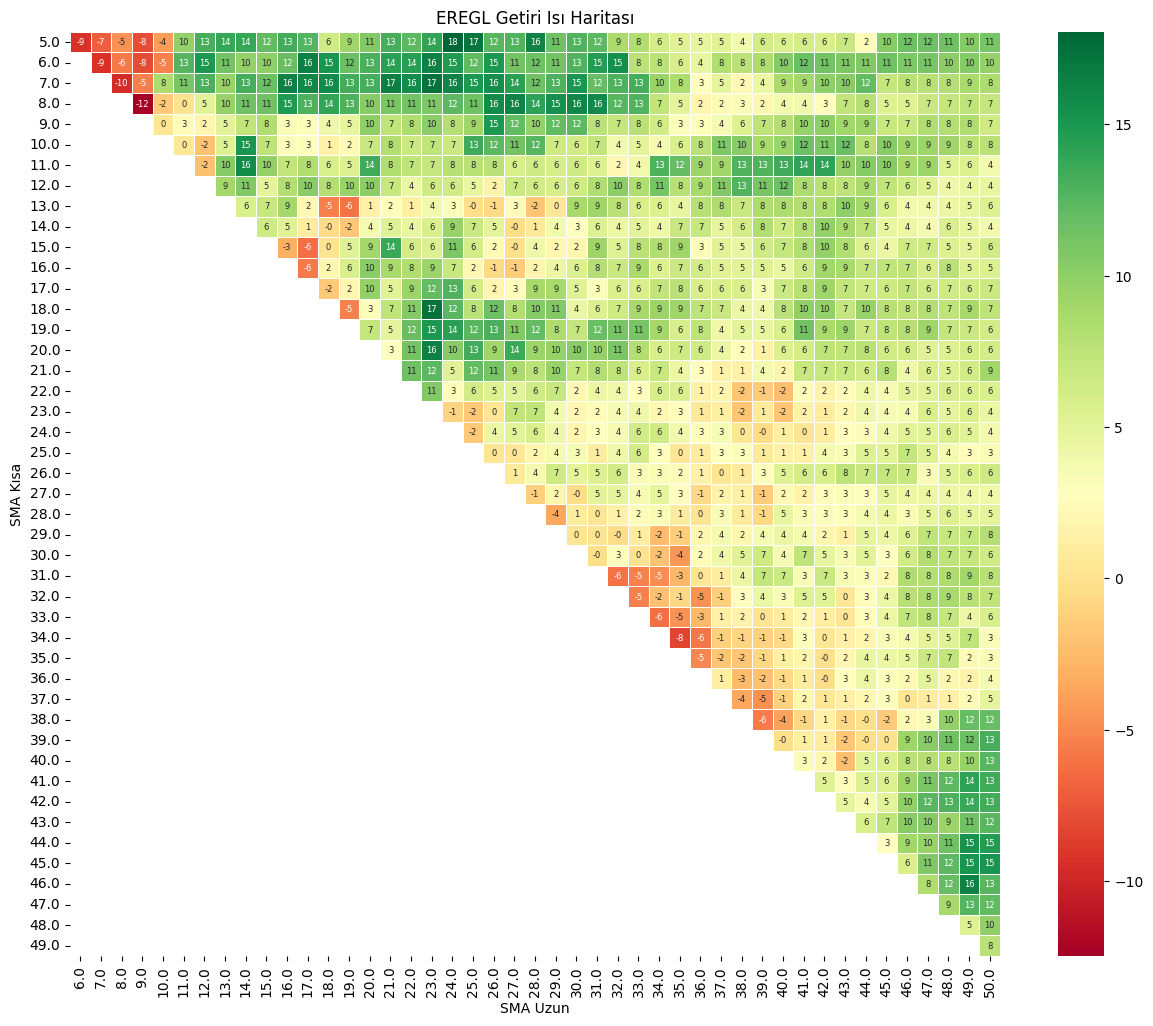

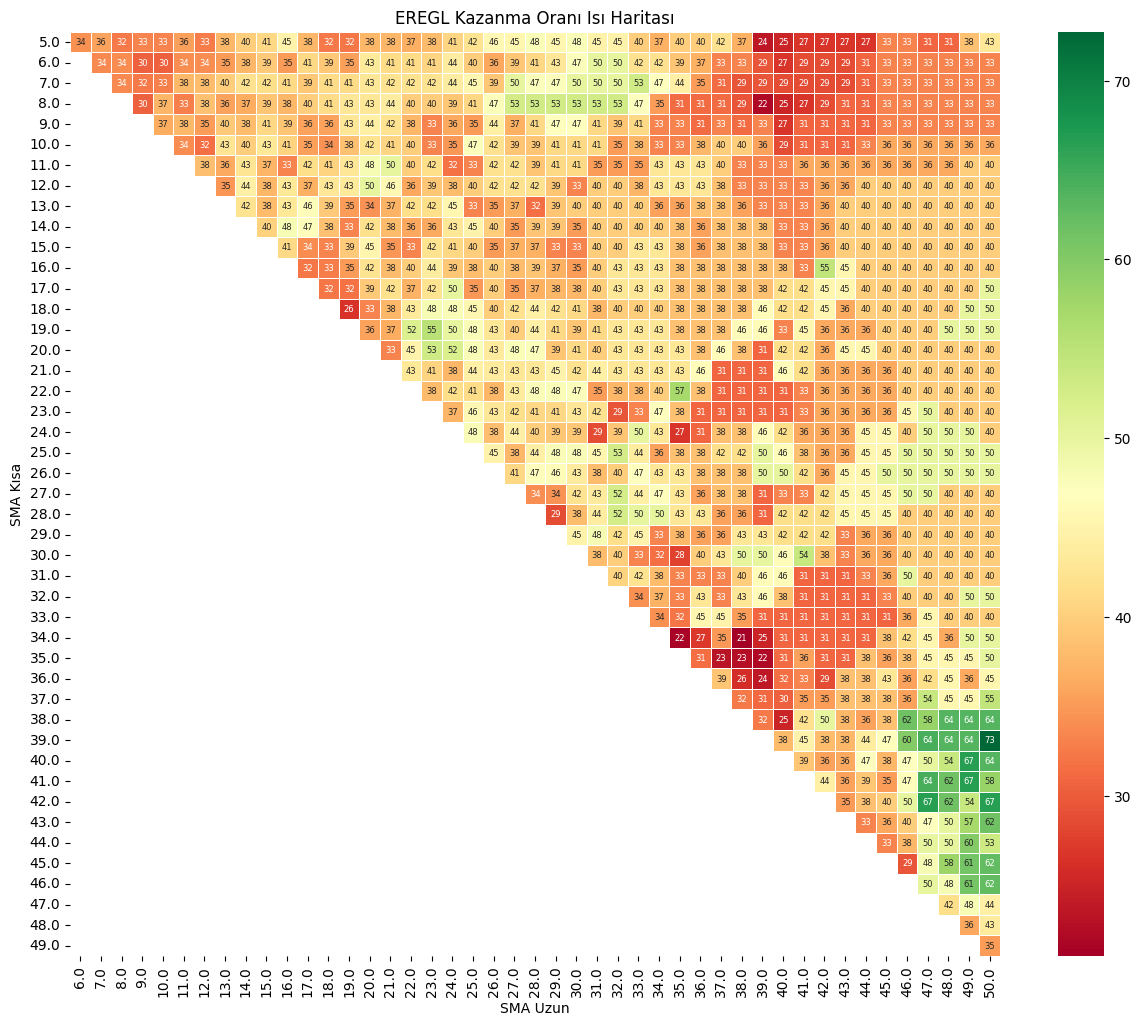

In [ ]:
#Kütüphanelerin yüklenmesi
!pip install git+https://github.com/rongardF/tvdatafeed
!pip install tradingview-screener
!pip install backtesting


#kütüphanelerin çağırılması
import pandas as pd
from tvDatafeed import TvDatafeed, Interval
from backtesting import Backtest, Strategy

#Tradingview Kütüphanesini açıyoruz.
tv = TvDatafeed()

#Hisse Adını Tanımlıyoruz.
Hisse = "EREGL"

#Hisse Verilerini Tradingview Kütüphanesinden çekiyoruz.
data = tv.get_hist(symbol=Hisse, exchange='BIST', interval=Interval.in_1_hour, n_bars=1000)
print(data)

#SMA hesaplamasını tanımlıyoruz.
def sma(series, length):
    calc = series.rolling(window=length).mean()
    return calc

#Her Zaman kullanacağımız Stratejimizi hazırlıyoruz.
class Strategy(Strategy):
    def init(self):
        pass
    def next(self):
        if self.data['Entry'] == True and not self.position:
            self.buy()
        elif self.data['Exit'] == True:
            self.position.close()


#data başlıklarını yeniden isimlendiriyoruz
data.rename(columns={'open': 'Open', 'high': 'High',
                      'low': 'Low',
                      'close': 'Close',
                      'volume': 'Volume'},
                      inplace=True)

#Sonuçları Arşivlemek için İki Adet Boş dataframe yapısı oluşturuyoruz.
df_RE = pd.DataFrame(columns=['SMA Kısa', 'SMA Uzun','Getiri Yüzdesi'])
df_WR = pd.DataFrame(columns=['SMA Kısa', 'SMA Uzun','Kazanma Oranı'])

for i in range(5, 51):
    data['SMA_L1'] = sma(data['Close'], i)
    for j in range(i+1, 51):
        data['SMA_L2'] = sma(data['Close'], j)
        data['Entry'] = data['SMA_L1'] > data['SMA_L2']
        data['Exit'] = data['SMA_L1'] < data['SMA_L2']

        # Backtest yapımızı çağırıyoruz ve sonuçları inceliyoruz.
        bt = Backtest(data, Strategy, cash=100000, commission=0.002)
        Stats = bt.run()
        RE = round(Stats.loc['Return [%]'], 2)
        WR = round(Stats.loc['Win Rate [%]'], 2)
        df_RE.loc[len(df_RE)] = [i,j,RE]
        df_WR.loc[len(df_WR)] = [i,j,WR]

#Sonuçları plot ediyoruz.
df_RE = df_RE.sort_values(by='Getiri Yüzdesi', ascending=False)
df_WR = df_WR.sort_values(by='Kazanma Oranı', ascending=False)
print(df_RE)
print(df_WR)

#Isı Haritası oluşturmak için gerekli seaborn kütüphanesinin yüklenmesi
!pip install seaborn

#Görselleştirme kütüphanelerinin çağırılması
import seaborn as sns
import matplotlib.pyplot as plt

# Verileri pivot formata getiriyoruz
heatmap_data_1 = df_RE.pivot(index='SMA Kısa', columns='SMA Uzun', values='Getiri Yüzdesi')
heatmap_data_2 = df_WR.pivot(index='SMA Kısa', columns='SMA Uzun', values='Kazanma Oranı')

# Plot the Getiri heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(heatmap_data_1, annot=True, fmt=".0f", cmap="RdYlGn", linewidths=.5, annot_kws={"size": 6})
plt.title('EREGL Getiri Isı Haritası')
plt.show()

# Plot the Kazanma Oranı heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(heatmap_data_2, annot=True, fmt=".0f", cmap="RdYlGn", linewidths=.5, annot_kws={"size": 6})
plt.title('EREGL Kazanma Oranı Isı Haritası')
plt.show()